# Generalized plane strain computations using `Real` elements

```{admonition} Objectives
:class: objectives

In this tour, we show how to perform 2D simulations in generalized plane strain conditions. As such computations involve degrees of freedom which are constants over the whole mesh, we will use so-called `Real` elements.$\newcommand{\bsig}{\boldsymbol{\sigma}}
\newcommand{\beps}{\boldsymbol{\varepsilon}}
\newcommand{\be}{\boldsymbol{e}}
\newcommand{\bu}{\boldsymbol{u}}
\newcommand{\bv}{\boldsymbol{v}}
\newcommand{\bT}{\boldsymbol{T}}
\newcommand{\bI}{\boldsymbol{I}}
\newcommand{\T}{^\text{T}}
\newcommand{\tr}{\operatorname{tr}}
\newcommand{\CC}{\mathbb{C}}
\newcommand{\RR}{\mathbb{R}}
\newcommand{\dOm}{\,\text{d}\Omega}
\newcommand{\dS}{\,\text{d}S}
\newcommand{\Neumann}{{\partial \Omega_\text{N}}}
\newcommand{\Dirichlet}{{\partial \Omega_\text{D}}}
\renewcommand{\div}{\operatorname{div}}
\newcommand{\utilde}[1]{\tilde{#1}}
\newcommand{\uttilde}[1]{\tilde{\tilde{#1}}}$
```

```{attention}
This tour requires `Real` function space support, which has been implemented in the `scifem` package and aims at providing missing functionalities to `FEniCSx` users. More details and installation instructions are to be found here https://github.com/scientificcomputing/scifem.
```

```{admonition} Download sources
:class: download

* {Download}`Python script<./generalized_plane_strain.py>`
* {Download}`Jupyter notebook<./generalized_plane_strain.ipynb>`
```

## Generalized plane strain conditions

We focus here on small strain elastic computations on a 2D domain $\Omega$. Common types of modeling hypotheses in 2D involve plane strain, plane stress conditions (see [](/tours/linear_problems/isotropic_orthotropic_elasticity/isotropic_orthotropic_elasticity.md)) or axisymmetric conditions (see [](/tours/linear_problems/axisymmetric_elasticity/axisymmetric_elasticity.md)). While plane strain (resp. plane stress) hypothesis refers to a situation with zero transverse and out-of-plane shear strains (resp. stresses), **generalized plane strain** (GPS) conditions refer to the case where the transverse strain $\varepsilon_{zz}$ is supposed to be a constant throughout the domain (out-of-plane shear strains are typically zero). The value of this constant must be fixed by prescribing an additional information, typically by enforcing a specific value of the resultant vertical force. Such conditions indeed generalize plane strain conditions since the latter are recovered if $\varepsilon_{zz}=0$, while being simpler than a fully 3D strain state. GPS are typically useful for translationally-invariant geometries along $z$, in presence of a known vertical loading (pipes, tunnels, beams).

### Governing equations

The 3D displacement field in generalized plane strain conditions is searched in the following form:

\begin{align*}
u_x(x,y,z) &= u(x,y) \\
u_y(x,y,z) &= v(x,y) \\
u_z(x,y,z) &= \varepsilon_{zz} z +  w_0
\end{align*}

where $u$ and $v$ are functions on the 2D domain $\Omega$ and $\varepsilon_{zz}$ and $w_0$ are constants ($w_0$ does not play any role in the following, it simply sets the global translation along $z$).

The resulting 3D strain field is thus of the form:

```{math}
:label: gps-strain
\beps(x,y,z) = \begin{bmatrix} \partial_x u & \frac{1}{2}(\partial_x v + \partial_y u) & 0 \\ \frac{1}{2}(\partial_x v + \partial_y u) & \partial_y v & 0 \\ 0 & 0 & \varepsilon_{zz}\end{bmatrix}
```

where the in-plane part depends on $(x,y)$ and the out-of-plane strain is indeed the constant $\varepsilon_{zz}$.

The stress field $\bsig$ is related to $\beps$ via the usual 3D linear elastic behavior $\bsig = \CC:\beps$. Owing to {eq}`gps-strain`, the 3D stress field depends on $(x,y)$ only. For isotropic elasticity, the out-of-plane stress also depends on $(x,y)$ since $\sigma_{zz}(x,y) = \lambda\tr(\beps)+2\mu\varepsilon_{zz} = \lambda(\varepsilon_{xx}(x,y)+\varepsilon_{yy}(x,y)) + (\lambda+2\mu)\varepsilon_{zz}$.

The stress field must satisfy the local balance equations:
\begin{equation*}
\div_\text{3D}\bsig + \boldsymbol{f} = 0
\end{equation*}
in presence of a body force $\boldsymbol{f}$. We assume that the latter possesses in-plane components only to comply with the GPS conditions. In this case, local balance reduces to the in-plane part only since $(\div_\text{3D}\bsig)\cdot\be_z = 0$:
\begin{equation*}
\div_\text{2D}\uttilde{\bsig} + \boldsymbol{f} = 0
\end{equation*}
where the undertilde notation refers to the in-plane part of the corresponding tensor/vector.

However, to fix the out-of-plane strain an additional global balance condition in the $z$-direction must be given. Typical use case are generally concerned with conditions of the form:
\begin{equation}
F_z = \int_{\Omega}\sigma_{zz} \dOm
\label{vert-equilibrium}
\end{equation}
where $F_z$ is the imposed vertical force.


### Weak formulation

In the following, we denote by $\bu(x,y) = u(x,y)\be_x+v(x,y)\be_y$ the in-plane displacement and $V$ its corresponding function space. The unknowns of the problem are then $(\bu,\varepsilon_{zz})\in V \times \RR$, justifying the use `Real` function space for discretizing $\varepsilon_{zz}$.

Similarly to [](/tours/linear_problems/isotropic_orthotropic_elasticity/isotropic_orthotropic_elasticity.md), the variational form reads here:

Find $\bu, \varepsilon_{zz} \in V\times \RR$ such that:

\begin{align*}
\int_\Omega \uttilde\bsig[u,\varepsilon_{zz}]:\nabla^\text{s} \bv \dOm = \int_\Omega \boldsymbol{f}\cdot\bv \dOm + \int_\Neumann \bT\cdot\bv \dS \quad \forall \bv \in V_0\\
\text{and} \int_\Omega \bsig_{zz}[u,\varepsilon_{zz}] \dOm = F_z\\
\end{align*}

The last condition can also be written in a weak form using the real test constant $\widehat{\varepsilon}_{zz}$ as:
\begin{align*}
\int_\Omega \bsig_{zz}[u,\varepsilon_{zz}]\widehat{\varepsilon}_{zz} \dOm &= F_z\widehat{\varepsilon}_{zz} \quad \forall \widehat{\varepsilon}_{zz}\in\RR \\
\Rightarrow \quad \int_\Omega \bsig_{zz}[u,\varepsilon_{zz}]\widehat{\varepsilon}_{zz} \dOm &= \int_\Omega \dfrac{F_z}{S}\widehat{\varepsilon}_{zz} \dOm \quad \forall \widehat{\varepsilon}_{zz}\in\RR
\end{align*}
where $S=|\Omega|$ is the area of the 2D domain.

Both weak forms, respectively referring to the in-plane and out-of-plane equilibrium, can therefore be merged in the single mixed 3D variational form as follows:

Find $\bu, \varepsilon_{zz} \in V\times \RR$ such that:

```{math}
:label: gps-weak-form

\int_\Omega \bsig[u,\varepsilon_{zz}]:\beps[\bv,\widehat{\varepsilon}_{zz}] \dOm = \int_\Omega \boldsymbol{f}\cdot\bv \dOm + \int_\Neumann \bT\cdot\bv \dS + \int_\Omega \dfrac{F_z}{S}\widehat{\varepsilon}_{zz} \dOm \quad \forall (\bv,\widehat{\varepsilon}_{zz}) \in V_0\times\RR
```

where the first term involves the fully 3D stress tensor and the 3D strain variation $\beps[\bv,\widehat{\varepsilon}_{zz}]$ corresponding to {eq}`gps-strain` for the test fields $(\bv,\widehat{\varepsilon}_{zz})$.

## Implementation

The problem consists in a quarter of the 2D cross-section of a hollow cylinder, as considered in [](/tours/linear_problems/axisymmetric_elasticity/axisymmetric_elasticity.md). When importing the modules, we will especially need the `create_real_functionspace` from`scifem`.

In [48]:
import gmsh
from mpi4py import MPI
from petsc4py import PETSc
import ufl
from dolfinx import fem, io, plot
import dolfinx.fem.petsc
from dolfinx.cpp.la.petsc import get_local_vectors
from scifem import create_real_functionspace

hsize = 0.2

Re = 11.0
Ri = 9.0

In [49]:
gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 0)  # to disable meshing info
gdim = 2
model_rank = 0
gmsh.model.add("Model")

geom = gmsh.model.geo
center = geom.add_point(0, 0, 0)
p1 = geom.add_point(Ri, 0, 0)
p2 = geom.add_point(Re, 0, 0)
p3 = geom.add_point(0, Re, 0)
p4 = geom.add_point(0, Ri, 0)

x_radius = geom.add_line(p1, p2)
outer_circ = geom.add_circle_arc(p2, center, p3)
y_radius = geom.add_line(p3, p4)
inner_circ = geom.add_circle_arc(p4, center, p1)

boundary = geom.add_curve_loop([x_radius, outer_circ, y_radius, inner_circ])
surf = geom.add_plane_surface([boundary])

geom.synchronize()

gmsh.option.setNumber("Mesh.CharacteristicLengthMin", hsize)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", hsize)

gmsh.model.addPhysicalGroup(gdim, [surf], 1)
gmsh.model.addPhysicalGroup(gdim - 1, [x_radius], 1, name="bottom")
gmsh.model.addPhysicalGroup(gdim - 1, [y_radius], 2, name="left")
gmsh.model.addPhysicalGroup(gdim - 1, [outer_circ], 3, name="outer")


gmsh.model.mesh.generate(gdim)

domain, _, facets = io.gmshio.model_to_mesh(
    gmsh.model, MPI.COMM_WORLD, model_rank, gdim=gdim
)
gmsh.finalize()

The 3D strain expression {eq}`gps-strain` is defined as a function of both the in-plane displacement and the out-of-plane strain. The same is done for
the 3D stress obtained from 3D linear elasticity.

In [50]:
def eps(v, ezz):
    return ufl.sym(
        ufl.as_tensor(
            [
                [v[0].dx(0), v[0].dx(1), 0],
                [v[1].dx(0), v[1].dx(1), 0],
                [0, 0, ezz],
            ]
        )
    )


E = fem.Constant(domain, 1e5)
nu = fem.Constant(domain, 0.3)
mu = E / 2 / (1 + nu)
lmbda = E * nu / (1 + nu) / (1 - 2 * nu)


def sigma(v, ezz):
    return lmbda * ufl.tr(eps(v, ezz)) * ufl.Identity(3) + 2.0 * mu * eps(v, ezz)

A mixed function space involving a standard $P_2$-Lagrange space for the displacement and a `Real` function space is defined.

In [51]:
V = fem.functionspace(domain, ("P", 2, (gdim,)))
R = create_real_functionspace(domain)
W = ufl.MixedFunctionSpace(V, R)
du, dezz = ufl.TrialFunctions(W)
u_, ezz_ = ufl.TestFunctions(W)

The weak form {eq}`gps-weak-form` is now defined. Loading consists of a spatially varying in-plane body force $\boldsymbol{f} = f \boldsymbol{x}$ and of an imposed resultant vertical force $F_z$. Mixed bilinear and linear weak forms are written and corresponding blocks of the mixed formulation are extracted using `ufl.extract_blocks`. The forms are then both compiled using `fem.form`.

In [52]:
Fz = fem.Constant(domain, 10.0)
f = fem.Constant(domain, 1.0)
dx = ufl.Measure("dx", domain=domain)
x = ufl.SpatialCoordinate(domain)
S = fem.assemble_scalar(fem.form(1 * dx))


a_form = ufl.inner(sigma(du, dezz), eps(u_, ezz_)) * dx
L_form = Fz / S * ezz_ * dx - ufl.dot(f * x, u_) * dx
a_blocked_compiled = fem.form(ufl.extract_blocks(a_form))
L_blocked_compiled = fem.form(ufl.extract_blocks(L_form))

We apply smooth contact conditions on the vertical $y=0$ (facet tag `2`) and the horizontal $x=0$ (facet tag `1`) boundaries.

In [53]:
Vx, _ = V.sub(0).collapse()
Vy, _ = V.sub(1).collapse()
bottom_dofsy = fem.locate_dofs_topological((V.sub(1), Vy), gdim - 1, facets.find(1))
top_dofsx = fem.locate_dofs_topological((V.sub(0), Vx), gdim - 1, facets.find(2))

# used for post-processing
bottom_dofsx = fem.locate_dofs_topological((V.sub(0), Vx), gdim - 1, facets.find(1))[1]

u0x = fem.Function(Vx)
u0y = fem.Function(Vy)
bcs = [
    fem.dirichletbc(u0x, top_dofsx, V.sub(0)),
    fem.dirichletbc(u0y, bottom_dofsy, V.sub(1)),
]

The block linear system is then explicitly constructed using PETSc. Mappings are used

In [54]:
A = dolfinx.fem.petsc.assemble_matrix_block(a_blocked_compiled, bcs=bcs)
A.assemble()
b = dolfinx.fem.petsc.assemble_vector_block(
    L_blocked_compiled, a_blocked_compiled, bcs=bcs
)

ksp = PETSc.KSP().create(domain.comm)
ksp.setOperators(A)
ksp.setType("preonly")
pc = ksp.getPC()
pc.setType("lu")
pc.setFactorSolverType("mumps")

# solve system
xh = dolfinx.fem.petsc.create_vector_block(L_blocked_compiled)
ksp.solve(b, xh)
xh.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

Mappings are then used to retrieve the corresponding local vector values of both unknowns.

In [55]:
maps = [(Wi.dofmap.index_map, Wi.dofmap.index_map_bs) for Wi in W.ufl_sub_spaces()]
u = fem.Function(V, name="Displacement")
x_local = get_local_vectors(xh, maps)
u.x.array[: len(x_local[0])] = x_local[0]
u.x.scatter_forward()
ezz = x_local[1][0]

We check that the computed resultant force indeed corresponds to the applied value.

In [56]:
print("Vertical strain", ezz)
print(
    "Computed resultant force",
    fem.assemble_scalar(fem.form(sigma(u, ezz)[2, 2] * dx)),
)

V0 = fem.functionspace(domain, ("DG", 0, (3, 3)))
sig_exp = fem.Expression(sigma(u, ezz), V0.element.interpolation_points())
sig = fem.Function(V0, name="Stress")
sig.interpolate(sig_exp)

Vertical strain 0.00030616332375614394
Computed resultant force 9.999999999996628


Finally, the different components of the stress field can be visualized using Pyvista. We can check that the vertical stress is indeed a spatially varying field with a non-zero imposed vertical force.

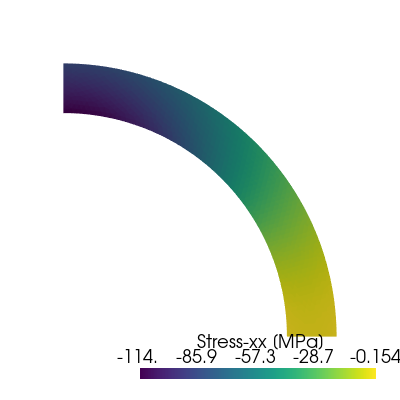

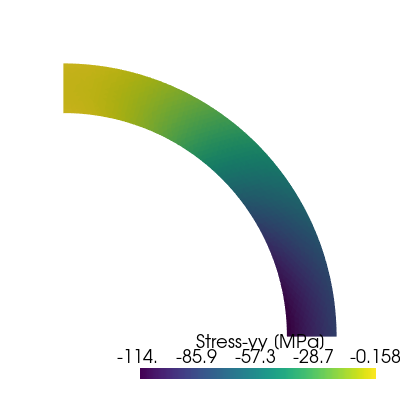

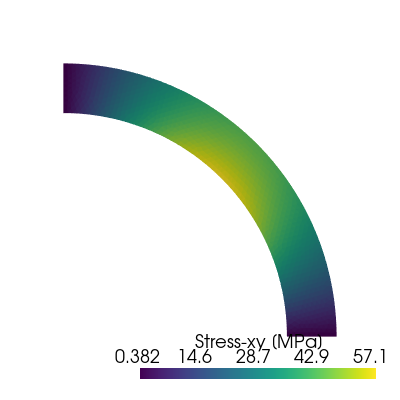

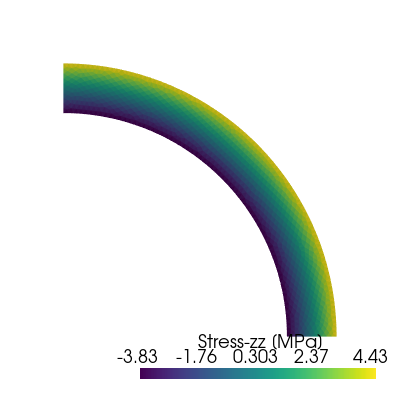

In [64]:
import pyvista

pyvista.set_jupyter_backend("static")


topology, cell_types, geometry = plot.vtk_mesh(domain, gdim)
sig_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

components = {"xx": 0, "yy": 4, "xy": 1, "zz": 8}
for i, comp in enumerate(["xx", "yy", "xy", "zz"]):
    pl = pyvista.Plotter()
    pl.window_size = (400, 400)
    title = f"Stress-{comp} [MPa]"
    sig_grid.cell_data[title] = sig.sub(components[comp]).collapse().x.array
    pl.add_mesh(
        sig_grid,
        scalars=title,
    )
    pl.view_xy()
    pl.show()